In [1]:
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

from IPython.display import HTML
import matplotlib.cm as cm
import numpy as np
from typing import Union
import math


In [2]:
import pandas as pd
import numpy as np
import sys
sys.path.append('..')
from lib.model_reduction_variant import Extractor
from lib.anomaly_detection import LOCIMatrix, LOCIMatrixNew
from lib.model_utils import export_rules_to_csv
from matplotlib import pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
pd.options.display.notebook_repr_html = False 
plt.rcParams['figure.dpi'] = 75 
sns.set_theme(style='darkgrid') 

In [3]:
from lib.model_utils import ModelUtil
model = ModelUtil(data_name = 'german_credit', model_name = 'RF')
paths = model.paths
mat, output = model.get_rule_matrix()

Test
Accuracy Score is 0.828
Precision Score is 0.8663101604278075
F1 Score is 0.88283378746594
Train
Accuracy Score is 0.8932692307692308


In [9]:

import copy
feature_pos = copy.deepcopy(model.feature_pos)

is_feature_categorical = {}
feature_val_idxs = {}
for i in model.feature_pos:
    if i == -1:
        continue
    feature, index = model.feature_pos[i]
    is_feature_categorical[feature] = index > 0

for i in model.feature_pos:
    if i == -1:
        continue
    feature, index = model.feature_pos[i]
    if is_feature_categorical[feature]:
        if feature not in feature_val_idxs:
            feature_val_idxs[feature] = []
        if i >= 0:
            feature_val_idxs[feature].append(i)

is_categorical = []
feature_range = []
for i in model.feature_pos:
    if i == -1:
        continue
    feature, index = model.feature_pos[i]
    is_categorical.append(is_feature_categorical[feature])
    feature_range.append(model.feature_range[feature])

n_features = len(is_categorical)
to_category_idx = [3]
for i in to_category_idx:
    name = model.feature_pos[i][0]
    is_categorical[i] = True
    feature_len =  model.feature_range[name][1] - model.feature_range[name][0]
    idx = [i for i in range(n_features, n_features + feature_len)]
    for it, j in enumerate(idx):
        feature_pos[j] = (name, it)
    feature_val_idxs[name] = idx
    n_features += feature_len

X = []
y = []
for p in paths:
    m = p['range']
    row = np.zeros(n_features)
    for i in m:
        if is_categorical[i]:
            if i in to_category_idx:
                left = int(max(feature_range[i][0], math.floor(m[i][0])))
                right = int(min(feature_range[i][1], math.ceil(m[i][1])))
                if feature_range[i][0] > 0:
                    left -= feature_range[i][0]
                    right -= feature_range[i][0]
                for j in range(left, right):
                    if j < len(feature_val_idxs[feature]):
                        row[feature_val_idxs[feature][j]] = 1
            else:
                if m[i][1] > 1:
                    row[i] = 1
                else:
                    if row[i] == 0:
                        feature, _ = model.feature_pos[i]
                        row[feature_val_idxs[feature]] = 1
                    row[i] = 0
        else:
            left = int(max(feature_range[i][0], m[i][0]))
            right = int(min(feature_range[i][1] - 1, m[i][1]))
            left = model.get_sum(i, 1, left) / len(model.X)
            right = model.get_sum(i, 1, right) / len(model.X)
            row[i] = (left + right) / 2 - 0.5
    for feature in feature_val_idxs:
        idx = feature_val_idxs[feature]
        tot = row[idx].sum()
        if tot > 0:
            row[idx] /= tot

    X.append(row)
    y.append(p['output'])
X = np.array(X).astype('float')
lr_mat = X
y = np.array(y)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X[:], y[:])
y_pred = lr.predict(X)
from sklearn.metrics import accuracy_score, precision_score, f1_score
print('Accuracy Score is', accuracy_score(y, y_pred))
prob1 = lr.predict_proba(X)[:, 0] * (y != y_pred)
outlier1 = prob1.argsort()[-50:][::-1].tolist()
prob2 = lr.predict_proba(X)[:, 1] * (y != y_pred)
outlier2 = prob2.argsort()[-50:][::-1].tolist()

Accuracy Score is 0.7677259082910671


In [8]:
lr.fit(X[high_conf_idxes], y[high_conf_idxes])
y_pred = lr.predict(X[:])
from sklearn.metrics import accuracy_score, precision_score, f1_score
print('Accuracy Score is', accuracy_score(y[:], y_pred))
print('Precision Score is', precision_score(y[:], y_pred))
print('F1 Score is', f1_score(y[:], y_pred))

Accuracy Score is 0.7201117896698065
Precision Score is 0.9335299901671583
F1 Score is 0.778324315461551


In [5]:
high_conf_idxes = [i for i, p in enumerate(paths) if paths[i]['confidence'] > 0.8]

In [4]:
res = LOCIMatrixNew(mat, output=output, r = 0.2, metric = 'euclidean', n_ticks=100)
r = np.mean(res.sorted_dist[:, 20])

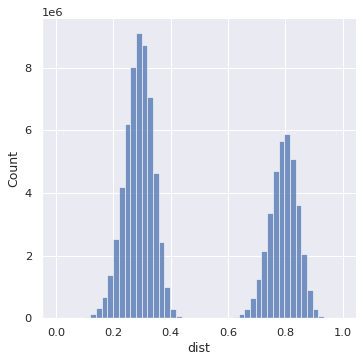

In [5]:
dist_data = pd.DataFrame({ 'dist': res.sorted_dist.reshape(-1) })
sns.displot(data=dist_data, x="dist", bins=50, log_scale=(False, False))
plt.show()

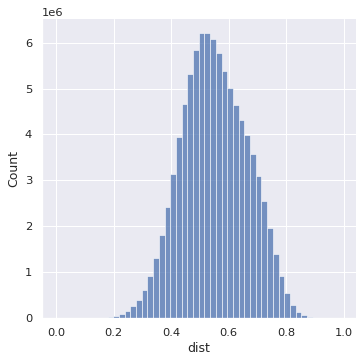

In [10]:
res2 = LOCIMatrixNew(mat, output=output, r = 0.2, output_alpha = 0.15, metric = 'euclidean', n_ticks=100)
dist_data = pd.DataFrame({ 'dist': res2.sorted_dist.reshape(-1) })
sns.displot(data=dist_data, x="dist", bins=50, log_scale=(False, False))
plt.show()

In [38]:
res.r = res.sorted_dist[:, 98].mean()
res.run()

r range: 0.193 - 0.995


True

In [13]:
res2.r = res2.sorted_dist[:, 98].mean()
res2.run()

r range: 0.328 - 0.992


True

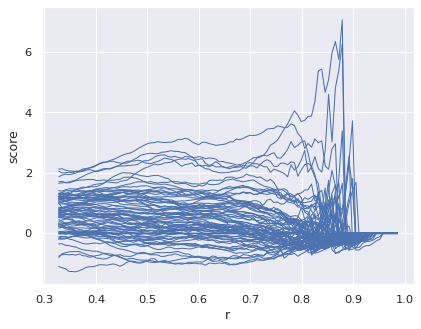

In [16]:
fig, ax = plt.subplots()
lines = []

xs = res2.rs
for x in range(2, 9000, 100):
    lines.append((res2.scores[x, :], 'b', x))

import random
random.shuffle(lines)
for (ys, color, index) in lines:
    ax.plot(xs, ys, color=color, linewidth=1)
ax.set_xlabel('r')
ax.set_ylabel('score')
plt.show()

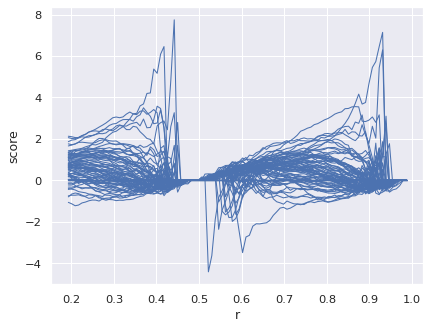

In [39]:
fig, ax = plt.subplots()
lines = []

xs = res.rs
for x in range(2, 9000, 100):
    lines.append((res.scores[x, :], 'b', x))

import random
random.shuffle(lines)
for (ys, color, index) in lines:
    ax.plot(xs, ys, color=color, linewidth=1)
ax.set_xlabel('r')
ax.set_ylabel('score')
plt.show()

In [33]:
predict_proba = lr.predict_proba(X)
score1 = np.array([predict_proba[i, 1 - y[i]] for i in range(predict_proba.shape[0])])
score2 = res2.check_consistency(0.328, [p['output'] for p in paths])
score2 = np.array(score2)
score_max = score2.max()
score_min = score2.min()
score2 = (score_max - score2) / (score_max - score_min)
score3 = np.array([p['confidence'] for p in paths])
score_max = score3.max()
score_min = score3.min()
score3 = (score_max - score3) / (score_max - score_min)

In [45]:
import matplotlib as mpl

class MplColorHelper:

  def __init__(self, cmap_name, start_val, stop_val):
    self.cmap_name = cmap_name
    self.cmap = plt.get_cmap(cmap_name)
    self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
    self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

  def get_rgb(self, val):
    return self.scalarMap.to_rgba(val)

for i in model.feature_pos:
    if model.feature_pos[i][0] not in feature_val_idxs:
        feature_val_idxs[model.feature_pos[i][0]] = i
        
max_ctr = lr.coef_[0].max()
min_ctr = -lr.coef_[0].min()
blues = MplColorHelper('Blues', 0, 1)
reds = MplColorHelper('Reds', 0, 1)

def display_rule(id, i):
    conds, output = model.interpret_path(model.paths[i])
    vec = lr_mat[i]
    text = '<b>IF </b> '
    for (feature, op, val) in conds:
        idx = feature_val_idxs[feature]
        ctr = np.sum(lr.coef_[0][idx] * vec[idx])
        if ctr > 0:
            ctr /= max_ctr
        else:
            ctr /= min_ctr
        cond_text = feature + ' ' + op + ' ' + str(val)
        if ctr > 0:
            rgb = blues.get_rgb(ctr * 0.9 + 0.1)
        else:
            rgb = reds.get_rgb(-ctr * 0.9 + 0.1)
        
        text_color = 'white' if np.abs(ctr) > 0.15 else 'black'
        bgcolor = 'rgb(%d,%d,%d)' % (int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255))
        if np.abs(ctr) < 0.03:
            bgcolor = 'white'

        text += ' <span style="background-color: %s; color:%s;">%s</span>, ' % \
            (bgcolor, text_color, cond_text)
    text = text[:-2] + ' '
    text += '<b>THEN </b> ' + output
    display(HTML('#%d, %d, LR: %.2f, Confidence: %.2f, Consistency: %.2f' % (id, i, score1[i], score3[i], score2[i])))
    display(HTML(text))


In [47]:
export_rules_to_csv('csv/0714_loci_top100', model, loci_outlier2)

In [46]:
loci_outlier2 = res.scores[:, 10].argsort()[-100:][::-1]
for it, i in enumerate(loci_outlier2):
    display_rule(it, i)

In [40]:
loci_outlier = res2.scores[:, 20].argsort()[-50:][::-1]
for it, i in enumerate(loci_outlier):
    display_rule(it, i)

In [62]:
for it, i in enumerate(outlier1 + outlier2):
    display_rule(it, i)

In [ ]:
res = LOCIMatrixNew(mat, r = 8, metric = 'euclidean', n_ticks=100)

<div class="alert alert-info">
  <strong>Consistency Top 50 (20 neighbors):</strong>
</div>

In [185]:
r = np.mean(res.sorted_dist[:, 20])
ret20 = res.check_consistency(r, [p['output'] for p in paths])
idx20 = np.array(ret20).argsort()[:50]
for it, i in enumerate(idx20):
    display_rule(it, i) 

<div class="alert alert-info">
  <strong>Consistency Top 50 (50 neighbors):</strong>
</div>

In [186]:
r50 = np.mean(res.sorted_dist[:, 50])
ret50 = res.check_consistency(r, [p['output'] for p in paths])
idx50 = np.array(ret50).argsort()[:50]
for it, i in enumerate(idx50):
    display_rule(it, i) 

<div class="alert alert-info">
  <strong>Consistency Top 50 (100 neighbors):</strong>
</div>

In [187]:
r100 = np.mean(res.sorted_dist[:, 100])
ret100 = res.check_consistency(r, [p['output'] for p in paths])
idx100 = np.array(ret100).argsort()[:50]
for it, i in enumerate(idx100):
    display_rule(it, i) 

<div class="alert alert-info">
  <strong>Low confidence Top 50:</strong>
</div>

In [188]:
for it, i in enumerate(low_conf_idxes):
    display_rule(it, i) 